### QAOA - Bayes
Applicazione di un processo di ottimizzazione bayesiana al QAOA.

### Imports

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram, plot_state_city
import random
import itertools
from tqdm import tqdm
from scipy.optimize import minimize

### Qaoa
alcuni metodi per runnare il qaoa con qiskit
- Create graph: crea un grafo random
- draw graph: disegna
- cost function: calcola l'energia classica di una configurazione di bits
- classical solution: calcola quale è la max clique provando tutte le 2^n combinazioni
- quantum algorithm: restituisce l'algorithm qusntistico che applica il qaoa
- Qaoa: accetta i parametri beta e gamma e restituisce l'energia dopo aver applicato un giro del circuito
- grid search: Cerca i parametri migliori con grid search
- plot_f1_landscape: disegna il landscape della funzione costo, dell'energia

In [2]:
G = nx.Graph()
G_comp = nx.Graph()
omega = 2
shots = 10000
N = 0

def create_graph(n, prob_conn, M = 0):
    global G, G_comp, omega, shots, N
    '''
    Creates a graph of N edges with a probablity of connectivity of each edge: prob_conn
    M decides the maxclique:
        if M is 0 the maxclique will be randomly generated
        if M>0 there will be a maxclique of at least M
    '''
    
    if prob_conn > 1:
        raise ValueError("Prob needs to be lower than 1")
    N = n
    print(N)
    prob_connectivity = prob_conn
    V   = np.arange(0,n,1)
    E = []
    
    #Creates generic graph with at least one connection per every vertex
    for i in range(n):
        one_edge_minimum = False
        for j in range(n):
            if i!=j and (j,i,1.0) not in E and np.random.rand()<prob_connectivity:
                E.append((i,j, 1.0))
                one_edge_minimum = True
        if not one_edge_minimum:
            choose = np.ones(n)/(n-1)
            choose[i] = 0
            E.append((i, np.random.choice(range(n), p = choose), 1))
    
    #Makes sure there is at least a M-large clique
    if M>0:
        max_clique = random.sample(range(0, n), M)
        for i in max_clique:
            for j in max_clique:
                if i!=j and ((j,i,1.0) not in E) and ((i,j,1.0) not in E):
                    E.append((i,j,1.0))
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    G_comp = nx.complement(G)  

def create_graph_specific(graph_type):
    '''
    Creates preset graphs decided by graph-type:
    graph-type:
        -- simple7: a simple 7 vertex graph with a 4 max clique
        -- simple4: a simple 4 vertex graph with a 3 max clique
        -- simple5: a simple 5 vertex graph with a 3 max clique
    '''
    global N, G, G_comp, omega
    if graph_type == 'simple7':
        N=7
        V   = np.arange(0,N,1)
        E = []
        E     =[(0,1,1.0),(0,2,1.0),(0,3,1),(1,2,1.0),(1,3,1),(3,2,1.0),(3,4,1.0),(2,5,1.0), (2,6,1)] 
    if graph_type == 'simple4':
        N=4
        V   = np.arange(0,N,1)
        E = []
        E     =[(0,1,1.0),(0,2,1.0),(1,2,1),(2,3,1.0)] 
        
    if graph_type == 'simple5':   
        N   = 5
        V   = np.arange(0,N,1)
        E = [(0,1,1), (1,2,1), (0,2,1), (2,3,1), (3,4,1)]
    
    if graph_type == 'simple6':
        N=6
        V   = np.arange(0,N,1)
        E = []
        E     = [(0, 2, 1), (0, 1, 1), (1, 4, 1), (1, 2, 1), (1, 3, 1), (2, 4, 1), (2, 3, 1), (3, 4, 1), (3, 5, 1)]
                   
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    G_comp = nx.complement(G)            

def draw_graph(comp = False):
    '''
    Draws given graph G and its complement G if comp = True
    '''
    if comp:
        G_complement = nx.complement(G)
        fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (4,2))
    else:
        fig, axis = plt.subplots(111, figsize = (2,2))
    
    colors       = ['r' for node in G.nodes()]
    default_axes = axis[0]
    pos          = nx.circular_layout(G)
    axis[0].set_title('Graph')
    first_graph = nx.draw_networkx(G, node_color=colors, node_size=200, alpha=1, ax=default_axes, pos=pos)
    
    if comp:
        colors       = ['b' for node in G_complement.nodes()]
        default_axes = axis[1]
        pos          = nx.circular_layout(G_complement)
        axis[1].set_title('Complementary Graph')
        nx.draw_networkx(G_complement, node_color=colors, node_size=200, alpha=1, ax=default_axes, pos=pos)

def cost_function(values):
    '''
    Evaluates cost of the +1/-1 combination of spins
    '''
    var = 1 - 2*values
    first_term = sum(var)
    second_term = 0
    for edge in G_comp.edges:
        second_term += omega*(var[edge[0]]*var[edge[1]] - var[edge[0]] - var[edge[1]])
    return first_term + second_term 


def classical_solution():    
    '''
    Runs through all 2^n possible configurations and estimates how many max cliques there are and plots one
    '''
    
    #Evaluate for every possible configuration
    lst = list(itertools.product([0, 1], repeat=len(g)))
    results = {}
    for i in tqdm(range(2**len(g))):
        results[lst[i]] = cost_function(np.array(lst[i]))
    
    print('All possible solutions: \n')
    sol = np.unique(list(results.values()), return_counts = True)
    print(sol[0])
    print(sol[1])
    d = dict((k, v) for k, v in results.items() if v == np.min(list(results.values())))
    print('There are {} MAXCLIQUE(S) with energy: \n'.format(len(d)), d)
    
    fig = plt.figure(figsize=(4, 4))
    val, counts = np.unique(list(results.values()), return_counts = True)
    plt.bar(val, counts)
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Statistics of solutions')

    #PLot one of the largest cliques
    fig = plt.figure(figsize = (2,2))
    plt.title('MaxClique')
    colors       = list(d.keys())[0]
    pos          = nx.circular_layout(g)
    nx.draw_networkx(g, node_color=colors, node_size=200, alpha=1, pos=pos)
    
    return d

def quantum_algorithm(gamma, beta):
    qc = QuantumCircuit(N,N)

    #prepare state
    qc.h(range(N))

    for edge in G_comp.edges:
        qc.rz(-2*gamma*omega, edge[1])
        qc.rz(-2*gamma*omega, edge[0])

        qc.rzz(2*gamma*omega, edge[1], edge[0])
        
    for i in G.nodes:
        qc.rz(2*gamma, i)

    #mixing
    qc.barrier()
    qc.rx(2*beta, range(N)) #rx = e^[-i(theta/2) X] 
    
    meas = QuantumCircuit(N,N)
    meas.barrier(range(N))
    meas.measure(range(N), range(N))

    return qc + meas

def QAOA(params):
    '''
    Applies QAOA
    '''
    gamma = params[0]
    beta = params[1]
    
    backend= Aer.get_backend("qasm_simulator")
    qc = quantum_algorithm(gamma, beta)
    simulate     = execute(qc, backend=backend, shots=shots)
    results = simulate.result()
    extimated_f1 = 0
    counts = results.get_counts()
    for combination in counts:
        comb_to_extimate = np.array([int(x) for x in combination])[::-1]
        extimated_f1 += cost_function(comb_to_extimate)*counts[combination]/shots 
    return extimated_f1

def grid_search(num_params):
    '''
    Grid search
    '''
    #Cretes params
    samp = np.linspace(0, np.pi, num_params)
    params = np.array(list((itertools.product(samp, repeat = 2))))
    gammas = params[:, 0]
    betas = params[:, 1]
    
    QAOA_results = []
    for i in tqdm(range(params.shape[0])):
        QAOA_results.append(QAOA([gammas[i], betas[i]]))
    
    return params, QAOA_results

def plot_f1_landscape(params, f1):
    fig = plt.figure()
    #ax = fig.gca(projection='3d')

    # Make data.
    X = np.unique(params[:,0])
    Y = np.unique(params[:,1])
    X, Y = np.meshgrid(X, Y)
    Z = np.reshape(f1, (len(X), len(Y)))

    # Plot the surface.
    #surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.imshow(Z, extent = [0, np.pi, 0, np.pi])
    plt.title('Grid Search: [{} x {}]'.format(len(X), len(X)))
    ticks = np.linspace(0, np.pi, len(X))[::4]
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.colorbar()
    plt.xlabel('\ gamma', fontsize=10)
    plt.ylabel('\ beta', fontsize = 10)

def minimize_QAOA():
    minimizer_results = minimize(QAOA, x0 =np.random.uniform(size = 2),
                        method = 'COBYLA', options = {'maxiter' : 1000})
    print(minizer_results)
    return minizer_results

### Gaussian Process to Approximate the f1 landscape of a graph

Generates $N_{train}$ points selected randomly on a grid $[gamma-extremes] \times [beta-extremes]$, trains a sklearn Gaussin Process Regressor with a kernel defined by kernel and tests it on $N_{test}$ samples uniformly picked on a grid $[0, max(gamma, betas)] \times [0, max(gamma, betas)] $. Result is compared to grid search

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [01:16<00:00, 11.77it/s]


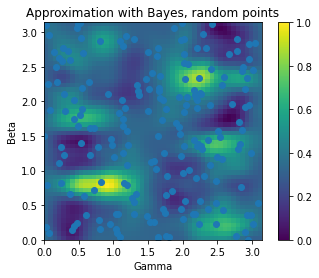

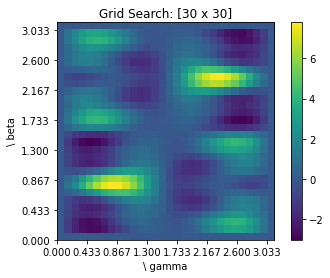

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from itertools import product

#First create the graph instance
create_graph_specific('simple4')

N_train = 200
N_test = 50 #Number of test elements
gamma_extremes = [0,np.pi]  #extremes where to search for the values of gamma and beta
beta_extremes = [0, np.pi]
#We start with N random points
X_train = []
y_train = []
for i in range(N_train):
    X = [np.random.uniform()*(gamma_extremes[1]-gamma_extremes[0]), np.random.uniform()*(beta_extremes[1]-beta_extremes[0])]
    X_train.append(X)
    Y = QAOA(X)
    y_train.append(Y)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X_train, y_train)

X= np.linspace(0, np.max([gamma_extremes, beta_extremes]), N_test)
X_test = list(product(X, X))
new_mean, sigma = gp.predict(X_test, return_std=True)
new_mean = np.reshape(new_mean, (N_test, N_test))
sigma = np.array(sigma)

X_train = np.array(X_train)
plt.title('Approximation with Bayes, random points')
plt.imshow(new_mean, extent = [gamma_extremes[0], gamma_extremes[1], beta_extremes[0], beta_extremes[1]])
plt.scatter(X_train[:,0], X_train[:,1])
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.colorbar()

#To confront with
if True:
    params, f1 = grid_search(30)
    plot_f1_landscape(params, f1)

### Bayesian Optimization to find the minimum of the f1 of a graph


In [10]:
from sklearn.utils.optimize import _check_optimize_result
from scipy.optimize import minimize

#Allows to change max_iter (see cell below) as well as gtol. It can be straightforwardly extended to other parameters
class MyGaussianProcessRegressor(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=2e05, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from itertools import product
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

#First create the graph instance
create_graph_specific('simple4')

#decide acquisition function
acq_function = 'EI'
N_train = 10
N_test = 50 #Number of test elements
iterations = 50
gamma_extremes = [0,np.pi]  #extremes where to search for the values of gamma and beta
beta_extremes = [0, np.pi]

#create dataset: We start with N random points
X_train = []   #data
y_train = []   #label
for i in range(N_train):
    X = [np.random.uniform()*(gamma_extremes[1]-gamma_extremes[0]), np.random.uniform()*(beta_extremes[1]-beta_extremes[0])]
    X_train.append(X)
    Y = QAOA(X)
    y_train.append(Y)

#create gaussian process and fit training data
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = MyGaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True, max_iter = 50000)
gp.fit(X_train, y_train)

#At each iteration we calculate the best point where to sample from
sample_points = []   #We save every point that was chosen to sample from
for i in range(iterations):
        # Test GP
        new_mean, new_sigma = gp.predict(X_test, return_std=True)
        
        #New_mean and new_sigma both are (N_test**2, ) arrays not reshaped yet
        mean_max = np.max(new_mean)
        mean_min = np.min(new_mean)
        
        
        #Now calculate acquisitition fn as the cumulative for every point centered around the maximum
        cdf = norm.cdf(x = new_mean, loc =  mean_max, scale = new_sigma)
        pdf = norm.pdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        #The qdf is instead the probability of being lower then the lowest value of the mean (where we wanto to pick the next_value)
        qdf = 1-norm.cdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        if acq_function == 'PI':
            #Next values is calculated as so just because argmax returns a number betwenn 1 and n_test instead of inside the interval
            value = np.argmax(qdf)
            next_point = X_test[value]
            
        if acq_function == 'EI':
            alpha_function = (new_mean - mean_min - 0.001)*qdf + new_sigma*pdf
            #argmax is a number between 0 and N_test**-1 telling us where is the next point to sample
            argmax = np.argmax(np.round(alpha_function, 3))
            next_point = X_test[argmax]
        
        print(next_point)
        X_train.append(next_point)
        y_next_point = QAOA(next_point)
        y_train.append(y_next_point)
        gp.fit(X_train, y_train)
        sample_points.append(next_point)

(0.5129130863003744, 2.3081088883516845)
(1.8593099378388571, 3.141592653589793)
(1.4105109873260295, 2.436337159926778)
(1.1540544441758422, 2.821021974652059)
(2.756907838864512, 0.4487989505128276)
(3.141592653589793, 0.4487989505128276)
(1.2822827157509358, 2.6286795672894185)
(2.8851361104396056, 0.7052554936630148)
(1.538739258901123, 2.6286795672894185)
(1.3463968515384828, 2.821021974652059)
(1.4746251231135763, 2.821021974652059)
(2.8851361104396056, 0.32057067893773394)
(1.4105109873260295, 2.756907838864512)
(2.9492502462271526, 0.1282282715750936)
(1.4105109873260295, 2.756907838864512)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype

(1.4105109873260295, 2.756907838864512)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(1.538739258901123, 2.6286795672894185)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.5129130863003744, 2.3081088883516845)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype

(1.4105109873260295, 2.756907838864512)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(1.1540544441758422, 2.500451295714325)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.5129130863003744, 2.3081088883516845)
(1.4105109873260295, 2.756907838864512)


C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages

(0.5129130863003744, 2.3081088883516845)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(1.1540544441758422, 2.821021974652059)
(1.9875382094139507, 1.0258261726007487)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.5129130863003744, 2.3081088883516845)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


(0.6411413578754679, 0.8334837652381083)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.5129130863003744, 2.3081088883516845)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(1.1540544441758422, 2.821021974652059)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(1.0258261726007487, 2.756907838864512)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(1.538739258901123, 2.6286795672894185)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(1.3463968515384828, 2.821021974652059)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(1.1540544441758422, 2.436337159926778)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(1.4105109873260295, 2.756907838864512)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


(2.3722230241392315, 2.3722230241392315)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


(1.0258261726007487, 0.7693696294505615)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.9617120368132019, 2.6927937030769655)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


(0.38468481472528077, 1.1540544441758422)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


(2.436337159926778, 2.436337159926778)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.38468481472528077, 1.1540544441758422)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.5129130863003744, 2.3081088883516845)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.5129130863003744, 2.3081088883516845)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(1.0258261726007487, 2.756907838864512)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.5129130863003744, 2.3081088883516845)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.5129130863003744, 2.3081088883516845)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.2564565431501872, 1.0899403083882955)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.38468481472528077, 1.1540544441758422)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.2564565431501872, 1.0899403083882955)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.5129130863003744, 2.3081088883516845)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\LEI00038\AppData\Local\Continuum\anaconda3\envs\qc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtyp

(0.2564565431501872, 1.0899403083882955)


<ipython-input-10-ae0d514ecb2a>:14: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [ ]:
plt.title('Approximation with Bayes, random points')
sample_points = np.array(sample_points)
plt.scatter(sample_points[:,0], sample_points[:,1])
plt.xlim([0, np.pi])
plt.ylim([0, np.pi])
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.colorbar()

plot_f1_landscape(params, f1)

In [ ]:
from itertools import product
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

l = 0.8
sigma = 3 

def kernel(a, b):
    a = np.array(a)
    b = np.array(b)
    K = np.zeros((len(a), len(b)))
    for i, ai in enumerate(a):
        for j, bj in enumerate(b):
            sqdist = (ai[0]-bj[0])**2 + (ai[1] - bj[1])**2
            K[i][j] = np.exp(-.5*sqdist/l)*sigma
    return K

def fit_predict(X_train, N_test):
    # Train and test GP
    K_ = kernel(X_train, X_train)
    X = np.linspace(0, np.max([gamma_extremes, beta_extremes]), N_test)
    X_test = list(product(X, X))
    L = np.linalg.cholesky(K_ + 1e-6*np.eye(len(X_train)))
    k_vector = np.array(kernel(X_train, X_test))
    y = np.linalg.solve(L, y_train)
    alpha_vector = np.linalg.solve(L.T, y)
    v_vector = np.linalg.solve(L, k_vector)
    f = y_train
    new_mean = np.dot(k_vector.T, alpha_vector)
    el = kernel(X_test, X_test) - np.dot(v_vector.T, v_vector)
    new_sigma = [el[i][i] for i in range(N_test)]
    return new_mean, new_sigma


#First create the graph instance
create_graph_specific('simple4')

acq_function = 'EI'
N_train = 10
N_test = 50 #Number of test elements
iterations = 50
gamma_extremes = [0,np.pi]  #extremes where to search for the values of gamma and beta
beta_extremes = [0, np.pi]

#We start with N random points 
X_train = []
y_train = []
for i in range(N_train):
    X = [np.random.uniform()*(gamma_extremes[1]-gamma_extremes[0]), np.random.uniform()*(beta_extremes[1]-beta_extremes[0])]
    X_train.append(X)
    Y = QAOA(X)
    y_train.append(Y)


new_mean, new_sigma = fit_predict(X_train, N_test)

sample_points = []   #We save every point that was chosen to sample from
for i in tqdm(range(iterations)):        
        #New_mean and new_sigma both are (N_test**2, ) arrays not reshaped yet
        mean_max = np.max(new_mean)
        mean_min = np.min(new_mean)        
        
        #Now calculate acquisitition fn as the cumulative for every point centered around the maximum
        cdf = norm.cdf(x = new_mean, loc =  mean_max, scale = new_sigma)
        pdf = norm.pdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        #The qdf is instead the probability of being lower then the lowest value of the mean (where we wanto to pick the next_value)
        qdf = 1-norm.cdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        if acq_function == 'PI':
            #Next values is calculated like so because argmax returns a number betwenn 1 and n_test instead of inside the interval
            value = np.argmax(qdf)
            next_point = X_test[value]
            
        if acq_function == 'EI':
            alpha_function = (new_mean - mean_min - 0.001)*qdf + new_sigma*pdf
            #argmax is a number between 0 and N_test**-1 telling us where is the next point to sample
            argmax = np.argmax(np.round(alpha_function, 3))
            next_point = X_test[argmax]
        
        print(next_point)
        X_train.append(next_point)
        y_next_point = QAOA(next_point)
        y_train.append(y_next_point)
        fit_predict(X_train, N_test)
        sample_points.append(next_point)    